# Polar H10 ACC-datastream
30.1.2022, Sakari Lukkarinen<br>
Metropolia University of Applied Sciences<br>


- [Polar Device Stream ACC](https://github.com/pareeknikhil/biofeedback/tree/master/Polar%20Device%20Data%20Stream/Accelerometer)
- [Bleak documentation](https://bleak.readthedocs.io/en/latest)
- [Polar SDK](https://www.polar.com/en/developers/sdk)
    - [Technical documentation](https://github.com/polarofficial/polar-ble-sdk/tree/master/technical_documentation)
    - [Polar H10 heart rate sensor](https://www.polar.com/us-en/products/accessories/h10_heart_rate_sensor)


## Instructions

1. Change these parameters first. 
2. Select: Run  > Run all cells.
3. Scroll down and see the live recording.
4. Observe how many seconds it takes the streaming to be live.
5. Wait until the first test is over.
6. Change the `WAIT_N_SECONDS'
7. Then select: Kernel > Restart Kernel and Run All Cells.

In [1]:
## This is the device MAC ID, please update with your device ID
ADDRESS = "E3:7B:AA:2D:D5:CD"

# Recording length in seconds
REC_LENGTH = 60

# Wait period before recording starts
WAIT_N_SECONDS = 1

# Data is stored to
DATAFILE = "data.csv"

## Setup

In [2]:
%matplotlib inline
import os
import sys
import time
import math
import asyncio
import nest_asyncio
import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, clear_output
import seaborn as sns
#!pip install bleak
from bleak import BleakClient
from bleak.uuids import uuid16_dict

sns.set_theme()

nest_asyncio.apply()

In [3]:
""" Predefined UUID (Universal Unique Identifier) mapping are based on Heart Rate GATT service Protocol that most
Fitness/Heart Rate device manufacturer follow (Polar H10 in this case) to obtain a specific response input from 
the device acting as an API """
uuid16_dict = {v: k for k, v in uuid16_dict.items()}

## UUID codes
MODEL_NBR_UUID = "00002a24-0000-1000-8000-00805f9b34fb"
MANUFACTURER_NAME_UUID = "00002a29-0000-1000-8000-00805f9b34fb"
BATTERY_LEVEL_UUID = "00002a19-0000-1000-8000-00805f9b34fb"
PMD_SERVICE = "FB005C80-02E7-F387-1CAD-8ACD2D8DF0C8"
PMD_CONTROL = "FB005C81-02E7-F387-1CAD-8ACD2D8DF0C8"
PMD_DATA = "FB005C82-02E7-F387-1CAD-8ACD2D8DF0C8"

## Polar specific codes
ECG_WRITE = bytearray([0x02, 0x00, 0x00, 0x01, 0x82, 0x00, 0x01, 0x01, 0x0E, 0x00])
ACC_WRITE = bytearray([0x02, 0x02, 0x00, 0x01, 0xC8, 0x00, 0x01, 0x01, 0x10, 0x00, 0x02, 0x01, 0x08, 0x00])
START_PPG_STREAM = bytearray([0x02, 0x01, 0x00, 0x01, 0xC8, 0x00, 0x01, 0x01, 0x10, 0x00, 0x02, 0x01, 0x08, 0x00])
START_ECG_STREAM = bytearray([0x02, 0x00])
STOP_ECG_STREAM = bytearray([0x03, 0x00])
START_PPI_STREAM = bytearray([0x02, 0x03])
STOP_PPI_STREAM = bytearray([0x03, 0x03])

## Polar H10 sampling frequencies ##
ACC_SAMPLING_FREQ = 200
ECG_SAMPLING_FREQ = 130

## Support functions

In [4]:
acc_x_data = [0]
acc_y_data = [0]
acc_z_data = [0]
acc_session_time = [0]
t = [0]

## Bit conversion of the Hexadecimal stream
def data_conv(sender, data):
    if data[0] == 0x02:
        timestamp = convert_to_unsigned_long(data, 1, 8)
        frame_type = data[9]
        resolution = (frame_type + 1) * 8
        step = math.ceil(resolution / 8.0)
        samples = data[10:]
        offset = 0
        while offset < len(samples):
            x = convert_array_to_signed_int(samples, offset, step)
            offset += step
            y = convert_array_to_signed_int(samples, offset, step)
            offset += step
            z = convert_array_to_signed_int(samples, offset, step)
            offset += step

            acc_x_data.extend([x])
            acc_y_data.extend([y])
            acc_z_data.extend([z])
            acc_session_time.extend([timestamp])

def convert_array_to_signed_int(data, offset, length):
    return int.from_bytes(
        bytearray(data[offset : offset + length]), byteorder="little", signed=True,
    )

def convert_to_unsigned_long(data, offset, length):
    return int.from_bytes(
        bytearray(data[offset : offset + length]), byteorder="little", signed=False,
    )

## Data recorder

Stopping ACC data...
Data written to file: data.csv.
[CLOSED] application closed.


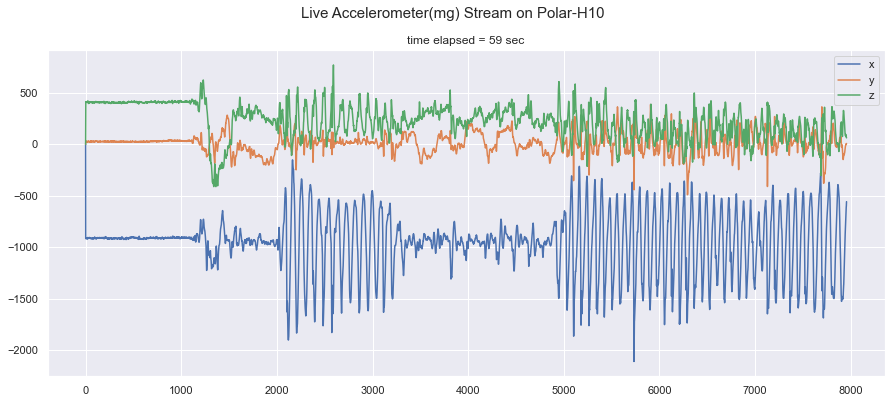

In [5]:
async def main(address):
   
    try:  
        print("[OPEN] application opened...")
        
        client = BleakClient(address)
        await client.connect()
        print('Connection opened.')
        
        model_number = await client.read_gatt_char(MODEL_NBR_UUID)
        print(f'Model Number: {"".join(map(chr, model_number))}')
        
        manufacturer_name = await client.read_gatt_char(MANUFACTURER_NAME_UUID)
        print(f'Manufacturer: {"".join(map(chr, manufacturer_name))}')

        battery_level = await client.read_gatt_char(BATTERY_LEVEL_UUID)
        print(f'Battery Level: {int(battery_level[0])}%')

        att_read = await client.read_gatt_char(PMD_CONTROL)
        if att_read[0] == 0x0F:
            features = att_read[1]
            ECG_SUPPORTED = features&1 != 0
            PPG_SUPPORTED = features&2 != 0
            ACC_SUPPORTED = features&4 != 0
            PPI_SUPPORTED = features&8 != 0
            print('ECG supported:', ECG_SUPPORTED)
            print('PPG supported:', PPG_SUPPORTED)
            print('ACC supported:', ACC_SUPPORTED)
            print('PPI supported:', PPI_SUPPORTED) 
            
        ## Start streaming accelerometer data ##
        await client.write_gatt_char(PMD_CONTROL, ACC_WRITE)

        ## Whenever there is data available, call data_conv
        await client.start_notify(PMD_DATA, data_conv)

        ## TypicalLY it takes 30 seconds to get the streaming to start
        print(f"Waiting for {WAIT_N_SECONDS} sec...")
        await asyncio.sleep(WAIT_N_SECONDS)
        time.sleep(WAIT_N_SECONDS)
    
        print("Collecting ACC data...")

        ## Create a graph
        fig = plt.figure(figsize=(15, 6))
        ax1 = fig.add_subplot(1, 1, 1)
        fig.suptitle("Live Accelerometer(mg) Stream on Polar-H10", fontsize=15)
        plt.xlabel("Time (sec)", fontsize=10)

        n = ACC_SAMPLING_FREQ

        if len(acc_x_data) == 0:
            print('Empty')
        
        while n < REC_LENGTH*ACC_SAMPLING_FREQ:

            ## Collecting ACC data for 1 second
            await asyncio.sleep(1)

            ax1.clear()
            #t = np.arange(len(acc_x_data))/ACC_SAMPLING_FREQ
            ax1.plot(acc_x_data, label = 'x')
            ax1.plot(acc_y_data, label = 'y')
            ax1.plot(acc_z_data, label = 'z')
            ax1.legend()
            ax1.set_title(f'time elapsed = {n/ACC_SAMPLING_FREQ:.0f} sec')
            display(fig)
            clear_output(wait=True)

            n = n + ACC_SAMPLING_FREQ
               
        ## Stop the stream once data is collected ##
        await client.stop_notify(PMD_DATA)
        print("Stopping ACC data...")
        
        ## Write data to DATAFILE ##
        t = np.arange(len(acc_x_data))/ACC_SAMPLING_FREQ
        df = pd.DataFrame({'t': t, 'x': acc_x_data, 'y': acc_y_data, 'z': acc_z_data}, index = None)
        df.to_csv(DATAFILE, index = False, float_format = "%.4f")
        print(f'Data written to file: {DATAFILE}.')
        df.head()    

           
    except Exception as e:
        print(e)
        print(f"Exception: {e=}, {type(e)=}")
        raise
    finally:
        await client.disconnect()
        print("[CLOSED] application closed.")

asyncio.run(main(ADDRESS))